<a href="https://colab.research.google.com/github/aureliodeboa/Calculo-Numerico/blob/main/Numerico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Calculo numérico**

---



# **Bibliotecas e Banco de dados**

Adiciona bibliotecas, puxa os dados do banco, seleciona a cidade desejada no ano de 2022 e seleciona apenas as colunas: **novos novos casos** e **numero total de casos**




In [1]:
import pandas as pd # dataframes
import matplotlib.pyplot as plt # plotting data
# import gzip file with cities data

df_cities = pd.read_csv("https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time_2022.csv.gz?raw=true", compression='gzip')

#df_campo = df_cities.loc[df_cities['city']=='Campo Formoso/BA' ,'totalCases']
df_cities["date"] = pd.to_datetime(df_cities["date"])
df = df_cities[df_cities['city']=='Recife/PE'] # escolhe a cidade
df = df[["date","newCases","totalCases"]] # get data, newCases e Total cases
df.reset_index(inplace=True, drop=True)   #reseto os index do df pois estavam bugados
#df_campo[df_campo["date"].dt.year == 2022]  # os dados já são desse periodo mes1 ao mes 12

print(df)

          date  newCases  totalCases
0   2022-01-01        89      161601
1   2022-01-02        19      161620
2   2022-01-03        21      161641
3   2022-01-04        86      161727
4   2022-01-05       163      161890
..         ...       ...         ...
360 2022-12-27       666      285159
361 2022-12-28       589      285748
362 2022-12-29       592      286340
363 2022-12-30       398      286738
364 2022-12-31         0      286738

[365 rows x 3 columns]


**CALCULO DA MEDIA MOVEL DE 7 DIAS**

In [ ]:
#from datetime import datetime, timedelta
df_media = pd.DataFrame() #cria um data frame vazio para guarda as medias de 7 dias
df_media = pd.DataFrame(df_media, columns=['date', 'media7'])  #defino a primeira coluna como data e a segunda como a media dos 7 dias anteriores
df_media["date"] = pd.to_datetime(df_media["date"])    # defino a coluna date como date time

#df2= df.set_index('date')
#df_media= df_media.set_index('date')
#print(df.iloc[0].date - timedelta(days=7)) #tava testando
#print(df2.loc[df.iloc[7].date - timedelta(days=7)].newCases) #tava testando

media=0 #variavel que acumula o numero de casos

for i in df.itertuples():  #percorro todos os dados para pode calcular a media
  media+=i.newCases       #media igual a media anterior o numero de casos atual
  if( i.date.day >= 7):   #esse if é para cacular a media movel apartir do 7 dia util do ano
   df_media.loc[len(df_media)]= [i.date, (media/7.0)]   #adciono o valor da media/7 no df das medias junto com a respectiva data
   media-= df.loc[i.Index-6].newCases              # tiro do acumulador o numero de casos de 7 dias atras para preservar a janela de 7 dias

#df_media
df.head(3)

,date,newCases,totalCases
0,2022-01-01,2,19470
1,2022-01-02,1,19471
2,2022-01-03,4,19475


**Depois achei essa função que faz todo meu trabalho de 8 horas em uma linha (CALCULO DA MEDIA MOVEL DE 7 DIAS E O GRAFICO)**


<Axes: xlabel='date'>

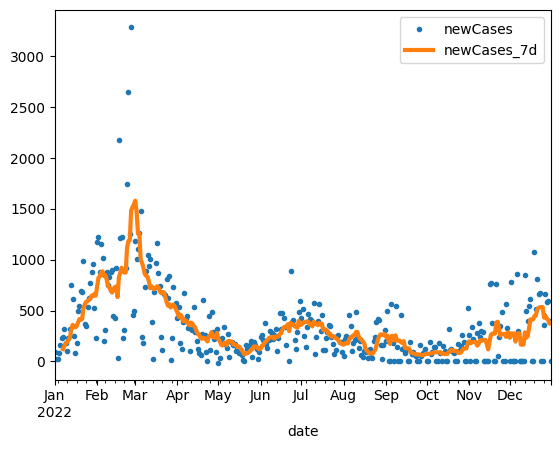

In [2]:

#df.plot(x="date",y="newCases")
#df_media.plot(x="date", y="media7")
ax = plt.gca()

_df = df
_df["newCases_7d"] = df["newCases"].rolling(7).mean() #ESSA LINHA VALE MILHOES
_df.plot(x = "date", y="newCases",marker=".",lw=0, ax=ax)
_df.plot(x = "date", y="newCases_7d",ax=ax,lw=3)

# **Metodo dos minimos quardrados **

In [14]:
from pandas._libs.tslibs import timestamps
import numpy as np
import math


_df['day'] =_df['date'].dt.day
_df['month'] =_df['date'].dt.month
_df['g1'] = _df['date'].dt.day * _df['date'].dt.day
_df['g2'] = _df['date'].dt.day
_df['y'] =   _df['newCases']
_df['previsao']= np.nan
_df['erro_relativo']= np.nan
_df['erro_medio']= np.nan

y_previsao=[]
y_dados=[]

g3= np.ones(21) # nem precisava disso
g1g1 = g1g2 = g1g3 = g2g3 = g3g3 = yg1 = yg2 = yg3= g2g2 = g3g3 = erro_ajuste = 0 #serão  os valores da matriz 3x3

for i in _df.itertuples():
  #acumula os valores moveis de 21 dias dos G's e dos YG's
 g1g1+= i.g1*i.g1
 g1g2+= i.g1*i.g2
 g1g3+= i.g1*g3[1]
 g2g2+= i.g2*i.g2
 g2g3+= i.g2*g3[1]
 g3g3+= g3[1]*g3[1]
 yg1+=  i.g1*i.y
 yg2+=  i.g2*i.y
 yg3+=  i.y*g3[1]

 # quando passar dos 21 dias, ira calcular o dia 21
 if(i.day > 21 or i.month > 1):

  A= np.array([[g1g1, g1g2,g1g3],[g1g2,g2g2,g2g3],[g1g3,g2g3,g3g3]]) #matriz A
  b= np.array([[yg1],[yg2],[yg3]])  #matriz b

  funcEstimativa = np.linalg.solve(A,b) #resolve o sistema linear

  previsao = (i.day**2)*(funcEstimativa[0]) + i.day*(funcEstimativa[1])+ (funcEstimativa[2]) #calcula apartir da função o valor estimado 'a previsão'

  y_previsao.append(previsao)
  y_dados.append(i.newCases)
  if(i.Index>41): # nesse momento terá se passado 21 dias de previsoes
    erro_ajuste = math.sqrt(np.square(np.subtract(y_dados, y_previsao)).mean())
    _df.iloc[[i.Index],-1]= float(erro_ajuste)
    y_previsao.pop(0)
    y_dados.pop(0)

  #este if trata quando tem divisao por zero
  if(i.newCases):
    erro_relativo = abs((previsao - i.newCases)/i.newCases)

  else:
   erro_relativo= abs((previsao - i.newCases)/previsao)
   #divisao por zero tratarr a if condition else b

  #tira dos acumuladores o valor de 21 dias atras, para que assim o proximo valor da  função seja baseada somente nos 21 dias anteriores
  g1g1 -= _df.loc[i.Index-21].g1 * _df.loc[i.Index-21].g1
  g1g2 -= _df.loc[i.Index-21].g1 * _df.loc[i.Index-21].g2
  g1g3 -= _df.loc[i.Index-21].g1
  g2g2 -= _df.loc[i.Index-21].g2 * _df.loc[i.Index-21].g2
  g2g3 -= _df.loc[i.Index-21].g2
  g3g3 -= 1
  yg1 -= _df.loc[i.Index-21].g1 * _df.loc[i.Index-21].y
  yg2 -=  _df.loc[i.Index-21].g2 * _df.loc[i.Index-21].y
  yg3 -= _df.loc[i.Index-21].y



  _df.iloc[[i.Index],-3]= float(previsao) #coloca os dados da previsao da ultima coluna
  _df.iloc[[i.Index],-2]= float(erro_relativo)

_df
dfinal= _df[["date","newCases","previsao","erro_relativo","newCases_7d","erro_medio"]]
dfinal


,date,newCases,previsao,erro_relativo,newCases_7d,erro_medio
0,2022-01-01,89,NaN,NaN,NaN,NaN
1,2022-01-02,19,NaN,NaN,NaN,NaN
2,2022-01-03,21,NaN,NaN,NaN,NaN
3,2022-01-04,86,NaN,NaN,NaN,NaN
4,2022-01-05,163,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
360,2022-12-27,666,427.154150,0.358627,451.714286,378.731112
361,2022-12-28,589,394.788538,0.329731,419.857143,366.591299
362,2022-12-29,592,406.711462,0.312987,410.142857,369.089222
363,2022-12-30,398,384.338933,0.034324,371.428571,359.387491


<Axes: xlabel='date'>

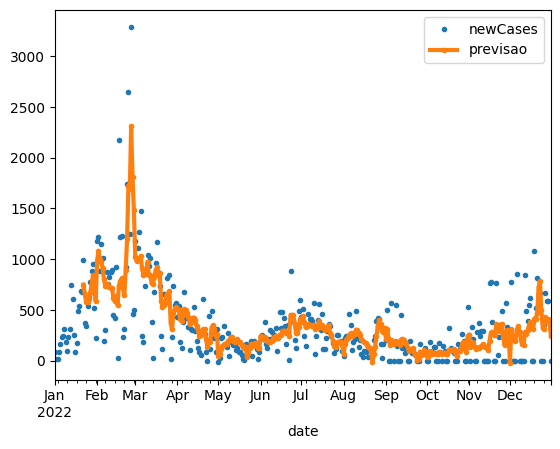

In [12]:
ax = plt.gca()

_df.plot(x = "date", y="newCases",marker=".",lw=0, ax=ax)
_df.plot(x = "date", y="previsao",marker=".",ax=ax,lw=3)


<Axes: xlabel='date'>

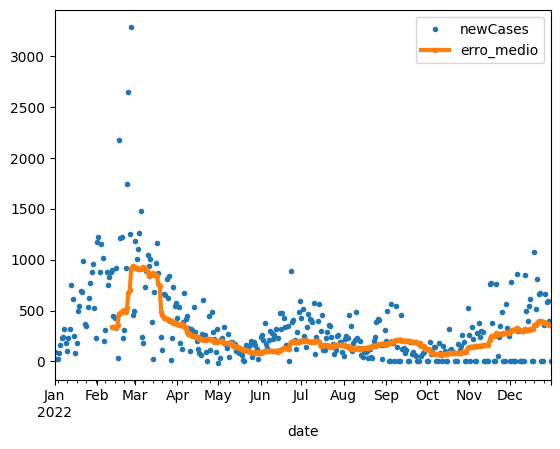

In [13]:
ax = plt.gca()

_df.plot(x = "date", y="newCases",marker=".",lw=0, ax=ax)
_df.plot(x = "date", y="erro_medio",marker=".",ax=ax,lw=3)